## Bayesian Optimization

In [ ]:
!pip install bayesian-optimization

In [ ]:
pip install pandas seaborn matplotlib openpyxl

In [ ]:
from scipy.stats import norm
from scipy.optimize import minimize
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from bayes_opt import BayesianOptimization
from scipy.optimize import NonlinearConstraint
from bayes_opt import acquisition

In [ ]:
df = pd.read_excel(r"/content/Data for BO updated.xlsx", engine="openpyxl")
print(df.columns, df.shape)
df = df[['Temp', 'Fe', 'Ni','Dol', 'Y_Syngas yield']]
df.tail(10)

Index(['Temp', 'Fe', 'Ni', 'Dol', 'Y_Syngas yield'], dtype='object') (46, 5)


,Temp,Fe,Ni,Dol,Y_Syngas yield
36,860,2.5,12.5,85,29.397400
37,800,5.0,10.0,85,28.534194
38,900,5.0,10.0,85,27.428658
39,875,2.0,3.0,95,26.322000
40,700,15.0,10.0,75,25.999954
41,700,5.0,10.0,85,24.972119
42,825,1.0,4.0,95,24.919500
43,800,0.0,5.0,95,24.696118
44,900,0.0,5.0,95,24.209914
45,700,0.0,5.0,95,21.992546


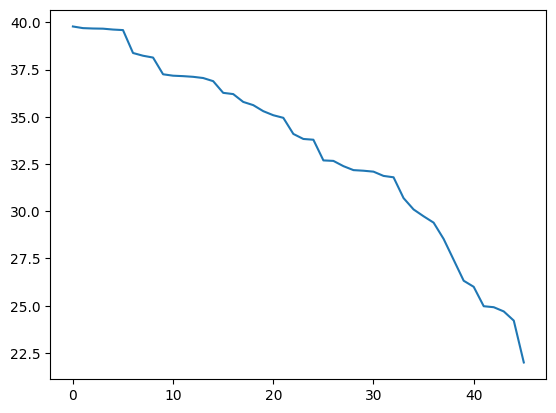

In [ ]:
# Now you can access columns by name
X_ = df[['Temp', 'Fe', 'Ni', 'Dol']].values
y_ = df[['Y_Syngas yield']].values
plt.plot(y_)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# scale features
# scaler = MinMaxScaler()
# model=scaler.fit(X_)
# X_ = model.transform(X_)

# compute required values
scaler = StandardScaler()
model1 = scaler.fit(X_)
X_ = model1.transform(X_)

In [ ]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.30, random_state=42)

In [ ]:
from sklearn.gaussian_process.kernels import RationalQuadratic, ConstantKernel, Matern, RBF

rbf = 1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)
rbf2 = ConstantKernel(0.1, (0.01, 10.0))
rbf3 = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 50.0), nu=0.25)
rbf4 = ConstantKernel(1.0) * RBF(length_scale=1.0)

R2 Score on Training Data: 0.994
R2 Score on Testing Data: 0.967
MSE VALUE ---:0.847
RMSE VALUE ---:0.920
MAE VALUE ----:0.765


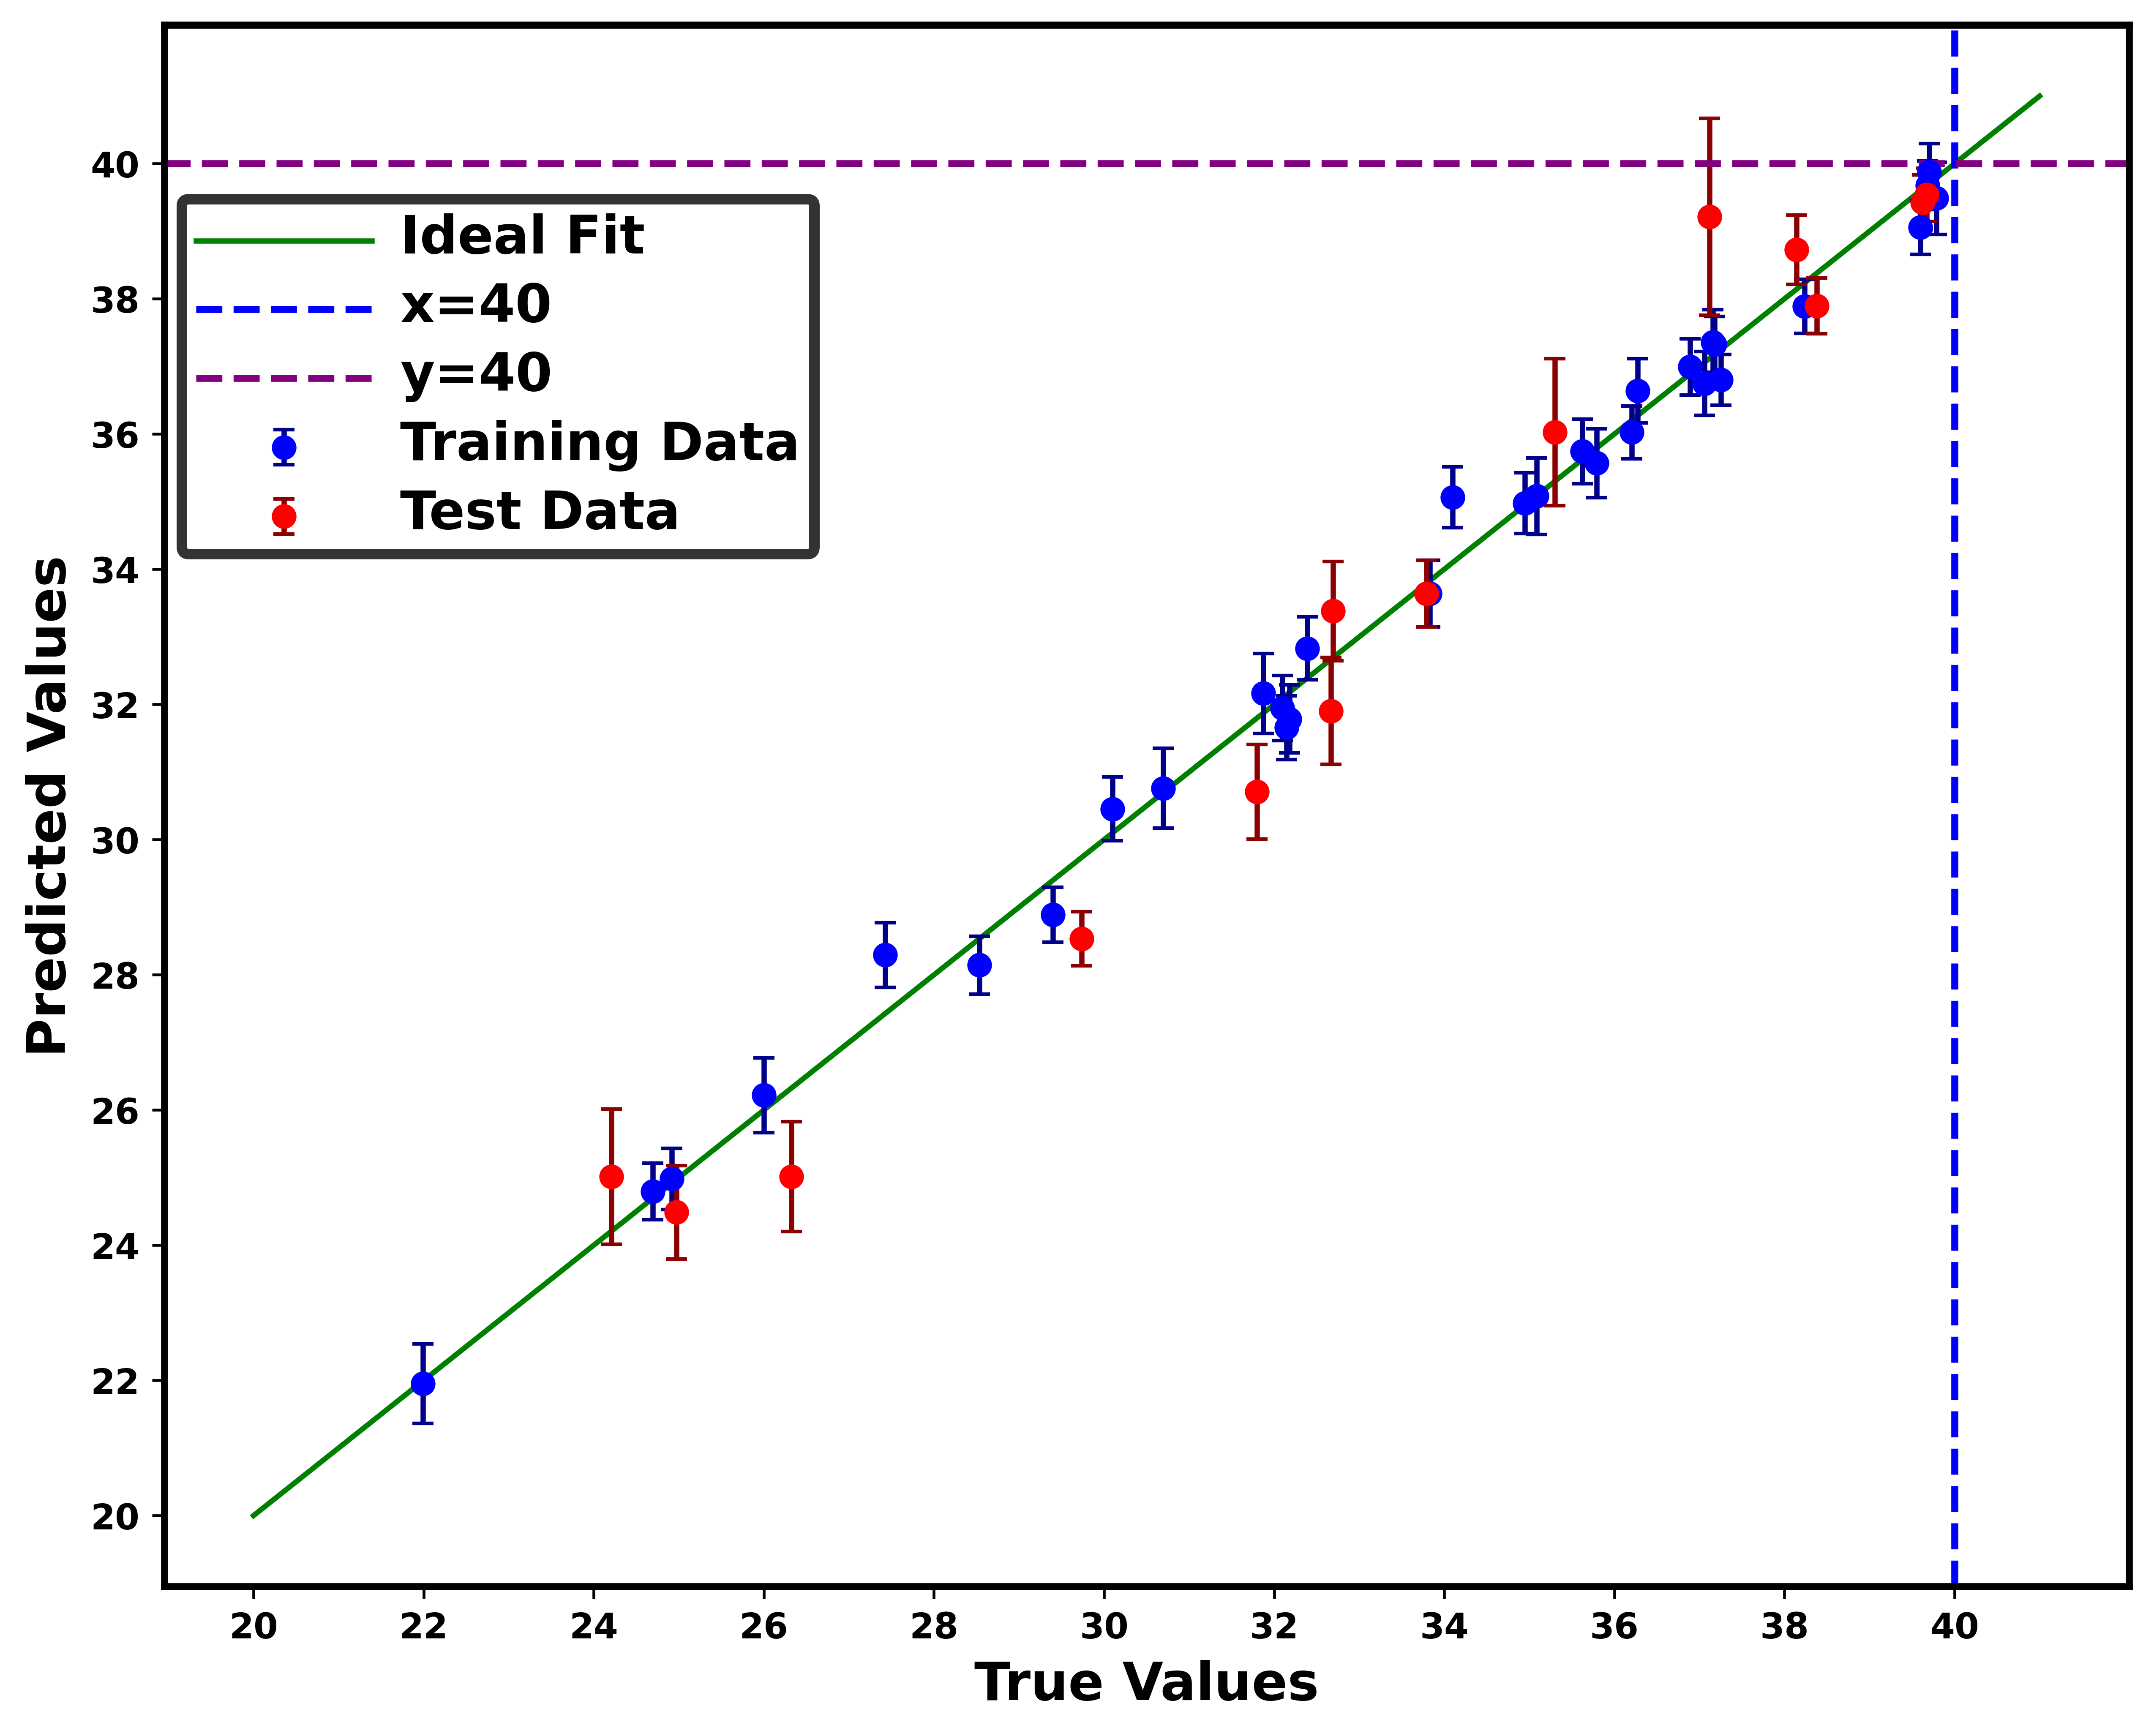

In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

# Define a kernel (Matern kernel with a constant)
kernel = C(1.0, (1e-5, 1e5)) * Matern(length_scale=1.0, length_scale_bounds=(1e-4, 1e4))

# Create a Gaussian Process model
model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.4, random_state= 42)

# Fit the model to the data
model.fit(X_train, y_train)

y_pred_train, sigma_train = model.predict(X_train, return_std=True)
y_pred_train = model.predict(X_train)

# Calculate R2 score
r2_train = r2_score(y_train, y_pred_train)
print(f"R2 Score on Training Data: {r2_train:.3f}")

y_pred_test, sigma_test = model.predict(X_test, return_std=True)
# Calculate R2 score
r2_test = r2_score(y_test, y_pred_test)
print(f"R2 Score on Testing Data: {r2_test:.3f}")

print("MSE VALUE ---:%.3f" % metrics.mean_squared_error(y_test, y_pred_test))
print("RMSE VALUE ---:%.3f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print("MAE VALUE ----:%.3f" % metrics.mean_absolute_error(y_test, y_pred_test))

# Plot the results with error bars
plt.figure(figsize=(10, 8), dpi=600)
plt.plot(np.arange(20, 42), np.arange(20, 42), label="Ideal Fit", color="green")

# # Plot training data with error bars
plt.errorbar(y_train, y_pred_train, yerr=sigma_train, fmt='o', label="Training Data", color="blue", ecolor='darkblue', capsize=3, linewidth=1.5)

# Plot testing data with error bars
plt.errorbar(y_test, y_pred_test, yerr=sigma_test, fmt='o', label="Test Data", color="red", ecolor='darkred', capsize=3, linewidth=1.5)

# Draw cross lines intersecting at 40
plt.axvline(x=40, color='blue', linestyle='--', linewidth=2, label='x=40')
plt.axhline(y=40, color='purple', linestyle='--', linewidth=2, label='y=40')

# plt.title("Gaussian Process Regression", fontsize = 14, fontweight='bold')
plt.xlabel("True Values", fontsize = 15, fontweight='bold')
plt.ylabel("Predicted Values", fontsize = 15, fontweight='bold')
plt.xticks(np.arange(20, 42, 2), fontweight='bold') # Set x-axis ticks with interval of 2
plt.yticks(np.arange(20, 42, 2), fontweight='bold') # Set y-axis ticks with interval of 2
# Get the legend
legend = plt.legend(handlelength=5, edgecolor='black',  loc='upper left', bbox_to_anchor=(0.0, 0.9)) # Increased handlelength

# Iterate through legend text and set font weight to bold
for text in legend.get_texts():
    text.set_fontweight('bold')
    text.set_fontsize(15) # Set font size

# Increase box line width
legend.get_frame().set_linewidth(3)  # Set linewidth to 2 (adjust as needed)



# Increase box line width
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)  # Set linewidth to 2 (adjust as needed)
# # Set tick label properties directly using fontdict
# plt.gca().xaxis.set_tick_params(labelsize=14, labelbottom=True, weight='bold')  # Adjust labelsize as needed
# plt.gca().yaxis.set_tick_params(labelsize=14, labelleft=True, weight='bold')

plt.savefig('GPR_fitting_with_error_bars.png',dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
# !pip install bayesian-optimization --upgrade

In [ ]:
print("Minimum")
for column in df.columns:
  print(column ,", Min>>", df[column].min(), "Max>>", df[column].max())

Minimum
Temp , Min>> 700 Max>> 950
Fe , Min>> 0.0 Max>> 50.0
Ni , Min>> 0.0 Max>> 50.0
Dol , Min>> 50 Max>> 95
Y_Syngas yield , Min>> 21.99254609124534 Max>> 39.7871


In [ ]:
# Read a specific sheet by name
# df_sample = pd.read_excel('/content/Data for BO updated.xlsx', sheet_name='Set-5', engine='openpyxl')
df_sample = pd.read_excel('/content/Data for BO updated.xlsx', engine='openpyxl')
# df_sample = df_sample[['Temp', 'Fe', 'Ni', 'Dol', 'Y_Syngas yield']]
new_data = pd.DataFrame({'Temp': [880.269], 'Fe': [0.9434], 'Ni': [4.1634], 'Dol':[95.0], 'Y_Syngas yield':[25.3361]})
new_data = pd.DataFrame({'Temp': [874.95], 'Fe': [0.9059], 'Ni': [14.2128], 'Dol':[85], 'Y_Syngas yield':[29.5433]})
new_data = pd.DataFrame({'Temp': [854.46], 'Fe': [0.5269], 'Ni': [24.6102], 'Dol':[75], 'Y_Syngas yield':[32.583]})
new_data = pd.DataFrame({'Temp': [890.02], 'Fe': [29.969], 'Ni': [10.492], 'Dol':[60], 'Y_Syngas yield':[37.099]})
new_data = pd.DataFrame({'Temp': [886.46], 'Fe': [37.2047], 'Ni': [13.254], 'Dol':[50], 'Y_Syngas yield':[39.697]})
df_ = pd.concat([df_sample, new_data], ignore_index=True)
# above 6 lines need to be used as per requirement and values of parameters need to be updated after every run as the Bayesian optimization proceeds.
df_= df_sample
# Display the first few rows of the DataFrame
df_.head(10)
df_.tail(10)

,Temp,Fe,Ni,Dol,Y_Syngas yield
36,860,2.5,12.5,85,29.397400
37,800,5.0,10.0,85,28.534194
38,900,5.0,10.0,85,27.428658
39,875,2.0,3.0,95,26.322000
40,700,15.0,10.0,75,25.999954
41,700,5.0,10.0,85,24.972119
42,825,1.0,4.0,95,24.919500
43,800,0.0,5.0,95,24.696118
44,900,0.0,5.0,95,24.209914
45,700,0.0,5.0,95,21.992546


In [ ]:
# #Initial data points to guide the search
X_sample = df_[['Temp', 'Fe', 'Ni', 'Dol']].values
y_sample = df_[['Y_Syngas yield']].values

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
Running simulation 1...
|   iter    |  target   |  allowed  |    X1     |    X2     |    X3     |    X4     |
-------------------------------------------------------------------------------------
| 1         | 31.496082 | True      | 850.55702 | 12.873329 | 9.8687021 | 76.500678 |
| 2         | 28.109807 | True      | 684.78452 | 28.125215 | 8.9423494 | 63.321089 |
| 3         | 34.119832 | True      | 736.02451 | 33.251791 | 14.705318 | 52.060514 |
| 4         | 35.996274 | True      | 881.53044 | 27.516639 | 8.6298642 | 63.152944 |
| 5         | 23.549432 | True      | 731.07632 | 7.6557276 | 1.3587236 | 90.355278 |
| 6         | 32.953096 | True      | 917.84820 | 17.093478 | 11.505433 | 71.910658 |
| 7         | 29.098944 | True      | 798.35122 | 5.4162986 | 11.983488 | 83.154688 |
| 8         | 36.301998 | True      | 874.83749 | 14.107541 | 34.293558 | 52.276689 |
| 9         | 26.084044 | True      | 769.52760 | 14

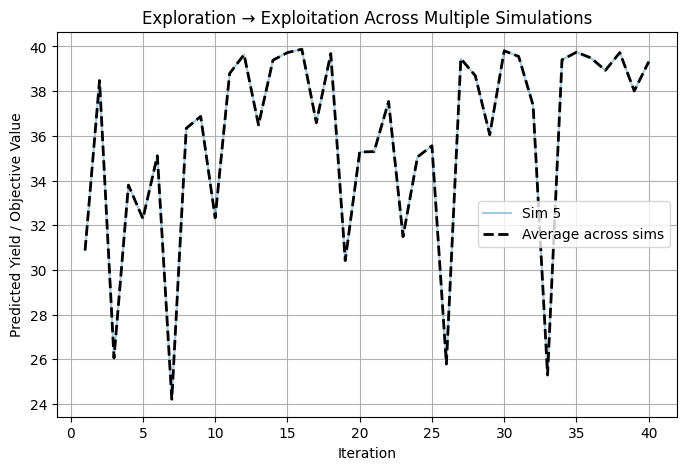

In [ ]:
# %time
# import numpy as np
# import pandas as pd
# from bayes_opt import BayesianOptimization
# from scipy.optimize import NonlinearConstraint
# from bayes_opt import acquisition

# # Define the bounds of the search space
# pbounds = {
#     'X1': (650, 950),  # Temperature
#     'X2': (0, 50),     # Fe composition
#     'X3': (0, 50),     # Ni composition
#     'X4': (50, 100)    # Dol composition
# }

# # Define the function to optimize
# def target_function(X1, X2, X3, X4):
#     """
#     Optimization function with constraints.
#     Replace with your actual target model/prediction.
#     """
#     x = np.array([X1, X2, X3, X4]).reshape(1, -1)
#     x = scaler.transform(x)
#     return model.predict(x)[0]  # Replace with your actual prediction model

# # Define the constraint
# def constraint_function(X1, X2, X3, X4):
#     return X2 + X3 + X4

# constraint_lower = np.array([99])
# constraint_upper = np.array([101])
# constraint = NonlinearConstraint(constraint_function, constraint_lower, constraint_upper)

# # Acquisition function
# # acquisition_function = acquisition.UpperConfidenceBound(kappa=5.0)
# acquisition_function = acquisition.ExpectedImprovement(xi=0.1)

# # Number of independent simulations
# num_simulations = 10

# # Store results for each simulation (all explored points, not just max)
# all_simulation_points = []
# simulation_results = []

# for sim in range(num_simulations):
#     print(f"Running simulation {sim + 1}...")

#     # Create optimizer with different random seed each run
#     optimizer = BayesianOptimization(
#         f=target_function,
#         pbounds=pbounds,
#         verbose=2,
#         acquisition_function=acquisition_function,
#         constraint=constraint,
#         random_state=sim,     # different seed each run
#         allow_duplicate_points=True
#     )

#     # Generate initial points that satisfy the constraint
#     initial_points = []
#     while len(initial_points) < 10: # Generate 10 initial points
#         random_point = optimizer.space.random_sample()
#         constraint_value = constraint_function(random_point[0], random_point[1], random_point[2], random_point[3])
#         if constraint_lower <= constraint_value <= constraint_upper:
#             initial_points.append(random_point)


#     # Register the initial points
#     for point in initial_points:
#         optimizer.probe(
#             params={
#                 'X1': point[0],
#                 'X2': point[1],
#                 'X3': point[2],
#                 'X4': point[3]
#             },
#             lazy=True # Use lazy=True as we will maximize later
#         )

#     # Perform the optimization
#     optimizer.maximize(init_points=0, n_iter=200) # init_points is 5 for broader exploration in the beginning

#     # Collect all sampled points
#     all_points = []
#     for i, res in enumerate(optimizer.res, 1):
#         row = res["params"]
#         row["target"] = res["target"]
#         row["iteration"] = i
#         row["simulation"] = sim + 1  # tag simulation number
#         all_points.append(row)

#     all_simulation_points.extend(all_points)   # add to global list
#     simulation_results.append(optimizer.max)

# # Convert to DataFrame for ALL simulations
# samples_df = pd.DataFrame(all_points)
# samples_df.to_csv("all_sampled_points_all_sims.csv", index=False)


# # ---------------- Visualization ----------------
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8,5))
# for sim in samples_df["simulation"].unique():
#     sim_data = samples_df[samples_df["simulation"] == sim]
#     plt.plot(sim_data["iteration"], sim_data["target"], alpha=0.4, label=f"Sim {sim}")

# # Plot average across simulations
# avg_targets = samples_df.groupby("iteration")["target"].mean()
# plt.plot(avg_targets.index, avg_targets.values, "k--", lw=2, label="Average across sims")

# plt.xlabel("Iteration")
# plt.ylabel("Predicted Yield / Objective Value")
# plt.title("Exploration → Exploitation Across Multiple Simulations")
# plt.legend()
# plt.grid(True)
# plt.show()

# #    # Collect ALL explored points from this run
# #     sim_points = pd.DataFrame(optimizer.res)  # all evaluated points
# #     sim_points["simulation"] = sim + 1
# #     all_simulation_points.append(sim_points)

# #     # Store best from this run too
# #     best_result = optimizer.max
# #     simulation_results.append(best_result)

# # # Combine all runs into one dataframe
# # all_points_df = pd.concat(all_simulation_points, ignore_index=True)

# # # Save all explored points
# # all_points_df.to_csv("all_explored_points.csv", index=False)

# # # Collect stats on best per run
# # best_results = [result for result in simulation_results]
# # best_targets = [result["target"] for result in best_results]
# # best_params = [result["params"] for result in best_results]

# # mean_best_target = np.mean(best_targets)
# # std_best_target = np.std(best_targets)

# # best_params_df = pd.DataFrame(best_params)
# # best_params_df['Target'] = best_targets
# # mean_best_params = best_params_df.mean().to_dict()

# # # Print results
# # print("\nResults from all simulations:")
# # for i, result in enumerate(simulation_results, 1):
# #     print(f"Simulation {i}: Best target = {result['target']} at {result['params']}")

# # print(f"\nMean of best targets: {mean_best_target}")
# # print(f"Standard deviation of best targets: {std_best_target}")
# # print(f"\nMean of best parameters: {mean_best_params}")

# # # Save best results
# # best_params_df.to_csv('best_params_summary.csv', index=False)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
Running simulation 1/10 ...
Running simulation 2/10 ...
Running simulation 3/10 ...
Running simulation 4/10 ...
Running simulation 5/10 ...
Running simulation 6/10 ...
Running simulation 7/10 ...
Running simulation 8/10 ...
Running simulation 9/10 ...
Running simulation 10/10 ...
Saved all sampled points to all_sampled_points_all_sims.csv


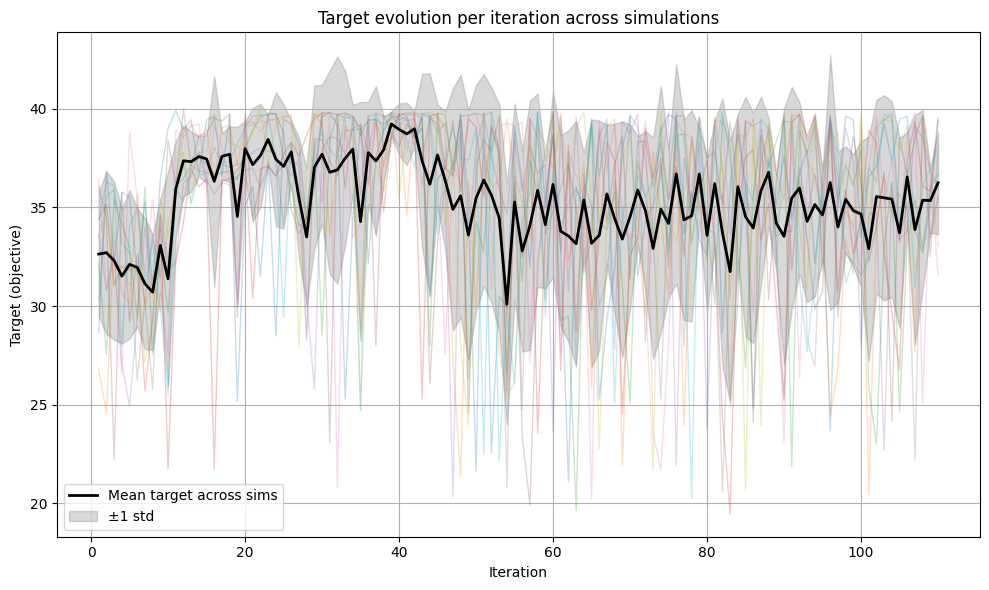

In [ ]:
# %time
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from bayes_opt import BayesianOptimization
# from scipy.optimize import NonlinearConstraint
# from bayes_opt import acquisition
# from itertools import combinations
# import math

# # --- User must provide these ---
# # target_function, scaler, model must already be defined in your environment

# # Define the bounds of the search space
# pbounds = {
#     'X1': (650, 950),  # Temperature
#     'X2': (0, 50),     # Fe composition
#     'X3': (0, 50),     # Ni composition
#     'X4': (50, 100)    # Dol composition
# }

# # Define the function to optimize (redefined for self-containment)
# def target_function(X1, X2, X3, X4):
#     """
#     Optimization function with constraints.
#     Uses the pre-trained model and scaler from previous cells.
#     """
#     x = np.array([X1, X2, X3, X4]).reshape(1, -1)
#     # Assuming 'scaler' and 'model' are defined in previously executed cells
#     x_scaled = scaler.transform(x)
#     return model.predict(x_scaled)[0]


# def constraint_function(X1, X2, X3, X4):
#     return X2 + X3 + X4

# constraint_lower = np.array([99])
# constraint_upper = np.array([101])
# constraint = NonlinearConstraint(constraint_function, constraint_lower, constraint_upper)

# acquisition_function = acquisition.ExpectedImprovement(xi=0.1)

# num_simulations = 10
# n_initial = 10   # number of initial feasible probes per simulation
# n_iter = 200     # BO iterations per simulation

# # Global storage
# all_simulation_points = []  # list of dicts: params, target, iteration, simulation

# for sim in range(num_simulations):
#     print(f"Running simulation {sim + 1}/{num_simulations} ...")
#     optimizer = BayesianOptimization(
#         f=target_function,
#         pbounds=pbounds,
#         verbose=0,
#         acquisition_function=acquisition_function,
#         constraint=constraint,
#         random_state=sim,
#         allow_duplicate_points=True
#     )

#     # --- generate and register initial feasible probes ---
#     initial_points = []
#     # Use optimizer.space.random_sample() which returns a 2D array [1, n_dims]
#     while len(initial_points) < n_initial:
#         rp = optimizer.space.random_sample()   # shape (1, dim) or (dim,)

#         # Check the dimensionality and extract parameters accordingly
#         if rp.ndim == 2:
#             x1, x2, x3, x4 = rp[0, 0], rp[0, 1], rp[0, 2], rp[0, 3]
#             point_to_append = rp[0] # Append the flattened 1D array
#         elif rp.ndim == 1:
#              x1, x2, x3, x4 = rp[0], rp[1], rp[2], rp[3]
#              point_to_append = rp # Append the 1D array
#         else:
#              # Handle unexpected dimensionality if necessary
#              print(f"Unexpected dimensionality of random_sample output: {rp.ndim}")
#              continue # Skip this point

#         if constraint_lower <= constraint_function(x1, x2, x3, x4) <= constraint_upper:
#             initial_points.append(point_to_append)


#     # Register the initial points
#     for point in initial_points:
#         optimizer.probe(
#             params={'X1': float(point[0]), 'X2': float(point[1]), 'X3': float(point[2]), 'X4': float(point[3])},
#             lazy=True
#         )

#     # Run BO (probes will be evaluated during maximize because lazy=True)
#     optimizer.maximize(init_points=0, n_iter=n_iter)

#     # Collect all sampled points for this simulation
#     # Note: optimizer.res is a list of eval records in the order they were evaluated
#     for i, rec in enumerate(optimizer.res, start=1):
#         row = rec["params"].copy()
#         # ensure floats (sometimes numpy scalar)
#         row = {k: float(v) for k, v in row.items()}
#         row["target"] = float(rec["target"])
#         row["iteration"] = int(i)            # iteration index within this simulation
#         row["simulation"] = int(sim + 1)     # 1-based simulation index
#         all_simulation_points.append(row)

# # Convert to DataFrame for all simulations
# samples_df = pd.DataFrame(all_simulation_points)
# samples_df = samples_df.sort_values(['simulation', 'iteration']).reset_index(drop=True)
# samples_df.to_csv("all_sampled_points_all_sims.csv", index=False)
# print("Saved all sampled points to all_sampled_points_all_sims.csv")

# # ---------------- Aggregate across simulations ----------------
# # Note: Some simulations may have different numbers of total evaluations (should be equal with fixed n_iter+n_initial)
# # We'll compute stats grouped by iteration index. If some sims have fewer iterations, groupby will handle that.

# agg_target = samples_df.groupby('iteration')['target'].agg(['mean', 'std', 'count']).reset_index()
# # Aggregate per parameter
# agg_params = samples_df.groupby('iteration')[['X1','X2','X3','X4']].agg(['mean','std']).reset_index()
# # Flatten column names
# agg_params.columns = ['iteration'] + [f"{p}_{stat}" for p in ['X1','X2','X3','X4'] for stat in ['mean','std']]

# # Compute diversity metric per iteration:
# # For each iteration, collect all sampled param vectors across simulations at that iteration,
# # compute mean pairwise Euclidean distance as a proxy for diversity (higher -> more exploration)
# diversity_records = []
# max_iter = samples_df['iteration'].max()
# for it in range(1, max_iter+1):
#     rows = samples_df[samples_df['iteration'] == it][['X1','X2','X3','X4']].values
#     n = len(rows)
#     if n <= 1:
#         mpd = 0.0
#     else:
#         # pairwise distances
#         s = 0.0
#         count = 0
#         for a,b in combinations(range(n),2):
#             dist = np.linalg.norm(rows[a] - rows[b])
#             s += dist
#             count += 1
#         mpd = s / count
#     diversity_records.append({'iteration': it, 'mean_pairwise_dist': mpd, 'n_samples': n})
# diversity_df = pd.DataFrame(diversity_records)

# # ---------------- PLOTTING ----------------
# import matplotlib.pyplot as plt

# # 1) Target: individual simulations faint + mean ± std bold
# plt.figure(figsize=(10,6))
# for sim in samples_df['simulation'].unique():
#     sim_df = samples_df[samples_df['simulation'] == sim]
#     plt.plot(sim_df['iteration'], sim_df['target'], alpha=0.25, lw=1)
# # mean and std
# plt.plot(agg_target['iteration'], agg_target['mean'], color='k', lw=2, label='Mean target across sims')
# plt.fill_between(agg_target['iteration'],
#                  agg_target['mean'] - agg_target['std'],
#                  agg_target['mean'] + agg_target['std'],
#                  color='gray', alpha=0.3, label='±1 std')
# plt.xlabel('Iteration')
# plt.ylabel('Target (objective)')
# plt.title('Target evolution per iteration across simulations')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig('exploration_vs_exploitation.png', dpi=600, bbox_inches="tight")
# plt.show()

# # # 2) Parameters: mean ± std vs iteration (four subplots)
# # fig, axs = plt.subplots(2,2, figsize=(12,8), sharex=True)
# # param_names = ['X1','X2','X3','X4']
# # titles = ['Temperature (X1)', 'Fe (X2)', 'Ni (X3)', 'Dol (X4)']
# # for ax, pname, title in zip(axs.ravel(), param_names, titles):
# #     mean_col = f"{pname}_mean"
# #     std_col  = f"{pname}_std"
# #     ax.plot(agg_params['iteration'], agg_params[mean_col], color='tab:blue', lw=2)
# #     ax.fill_between(agg_params['iteration'],
# #                     agg_params[mean_col] - agg_params[std_col],
# #                     agg_params[mean_col] + agg_params[std_col],
# #                     color='tab:blue', alpha=0.25)
# #     ax.set_ylabel(title)
# #     ax.grid(True)
# # axs[-1,-1].set_xlabel('Iteration')
# # plt.suptitle('Parameter means ± std across simulations (per iteration)')
# # plt.tight_layout(rect=[0,0,1,0.96])
# # plt.show()

# # # 3) Diversity (mean pairwise distance) vs iteration
# # plt.figure(figsize=(9,5))
# # plt.plot(diversity_df['iteration'], diversity_df['mean_pairwise_dist'], 'o-', lw=2)
# # plt.xlabel('Iteration')
# # plt.ylabel('Mean pairwise distance (parameter space)')
# # plt.title('Diversity of sampled designs across simulations (per iteration)')
# # plt.grid(True)
# # plt.tight_layout()
# # plt.show()

In [ ]:
%time
# Define the bounds of the search space
pbounds = {
    'X1': (650, 950),  # Temperature
    'X2': (0, 50),    # Fe composition
    'X3': (0, 50),    # Ni composition
    'X4': (50, 100)     # Dol composition
          }

# Define the function to optimize
def target_function(X1, X2, X3, X4):
    """
    Optimization function with constraints.
    Example function: Replace with your actual target model/prediction
    """
    x = np.array([X1, X2, X3, X4]).reshape(1, -1)
    x = scaler.transform(x)
    return model.predict(x)[0]  # Replace with your actual prediction model

def constraint_function(X1, X2, X3, X4):
    return X2+X3+X4

# Note that the constraint limit in case of one-dimensional constraints can be both an array of shape (1,) or a number.
constraint_lower = np.array([99])
constraint_upper = np.array([101])

constraint = NonlinearConstraint(constraint_function, constraint_lower, constraint_upper)

# acquisition_function = acquisition.UpperConfidenceBound(kappa=5.0)
acquisition_function = acquisition.ExpectedImprovement(xi=0.1)

num_simulations = 10
# Store results for each simulation
simulation_results = []
all_simulation_points = []

# Perform simulations
for sim in range(num_simulations):
    print(f"Running simulation {sim + 1}...")

    # Create a new optimizer for each simulation
    optimizer = BayesianOptimization(
    f=target_function,  # Function to optimize
    pbounds=pbounds,    # Search space bounds
    verbose=2,          # Verbosity of the output
    acquisition_function=acquisition_function,   #Define the acquisition function
    constraint=constraint,
    random_state=sim,     # Seed for reproducibility
    allow_duplicate_points=True  # Allow duplicate points
    )

    for x_row, y_val in zip(X_sample, y_sample):
      constraint_value = constraint_function(x_row[0], x_row[1], x_row[2], x_row[3])
      optimizer.register(
          params={
              'X1': x_row[0],
              'X2': x_row[1],
              'X3': x_row[2],
              'X4': x_row[3]
          },
          target=y_val[0],  # Use the corresponding target value
          constraint_value=constraint_value  # Pass the constraint value here
      )

    # Perform the optimization
    optimizer.maximize(init_points=0, n_iter=200)

     # Collect ALL explored points from this run
    sim_points = pd.DataFrame(optimizer.res)  # optimizer.res stores all evaluations
    sim_points["simulation"] = sim + 1
    all_simulation_points.append(sim_points)

#     # Store the best result from this simulation
#     best_result = optimizer.max
#     simulation_results.append(best_result)

# # Calculate statistics
# best_results = [result for result in simulation_results]
# best_targets = [result["target"] for result in best_results]
# best_params = [result["params"] for result in best_results]

# mean_best_target = np.mean(best_targets)
# std_best_target = np.std(best_targets)

# # Calculate average parameters
import pandas as pd
best_params_df = pd.DataFrame(best_params)
best_params_df['Target'] = best_targets
 mean_best_params = best_params_df.mean().to_dict()

 temp = []; ni = []; fe = []; dol = []; target = []

 # Print results
 print("\nResults from all simulations:")
 for i, result in enumerate(simulation_results, 1):
     print(f"Simulation {i}: Best target = {result['target']} at {result['params']}")

print(f"\nMean of best targets: {mean_best_target}")
print(f"Standard deviation of best targets: {std_best_target}")
print(f"\nMean of best parameters: {mean_best_params}")
# best_params_df.to_csv('best_params_50dol_1_iteration.csv', index=False)

# Combine all runs into one dataframe
all_points_df = pd.concat(all_simulation_points, ignore_index=True)

# Save all explored points
all_points_df.to_csv("all_explored_points.csv", index=False)

# Calculate statistics
mean_target = all_points_df["target"].mean()
std_target = all_points_df["target"].std()

print("\nOverall statistics across ALL explored points:")
print(f"Mean target = {mean_target}")
print(f"Std target = {std_target}")

# Optional: group by run and show best per run
best_per_run = all_points_df.groupby("simulation").apply(lambda df: df.loc[df["target"].idxmax()])
print("\nBest per run:")
print(best_per_run[["simulation", "target", "params"]])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs
Running simulation 1...
| 1         | 30.697421 | True      | 700.0     | 50.0      | 0.0       | 50.0      |
| 2         | 32.098708 | True      | 700.0     | 40.0      | 10.0      | 50.0      |
| 3         | 32.389890 | True      | 700.0     | 30.0      | 20.0      | 50.0      |
| 4         | 33.829717 | True      | 700.0     | 20.0      | 30.0      | 50.0      |
| 5         | 32.694814 | True      | 700.0     | 10.0      | 40.0      | 50.0      |
| 6         | 31.873255 | True      | 700.0     | 0.0       | 50.0      | 50.0      |
| 7         | 35.302034 | True      | 800.0     | 50.0      | 0.0       | 50.0      |
| 8         | 37.156866 | True      | 800.0     | 40.0      | 10.0      | 50.0      |
| 9         | 38.23738  | True      | 800.0     | 30.0      | 20.0      | 50.0      |
| 10        | 37.180325 | True      | 800.0     | 20.0      | 30.0      | 50.0      |
| 11        | 37.0574   | True      | 800.0     | 10

/tmp/ipython-input-2332495320.py:118: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_per_run = all_points_df.groupby("simulation").apply(lambda df: df.loc[df["target"].idxmax()])


In [ ]:
from bayes_opt import BayesianOptimization
from bayes_opt import acquisition
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.8198    | 3.109     |
| 2         | 0.746     | 7.775     |


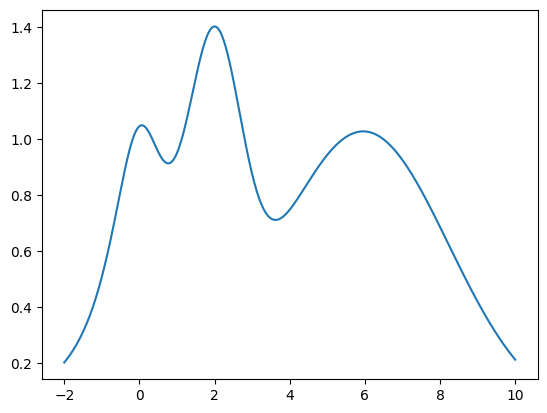

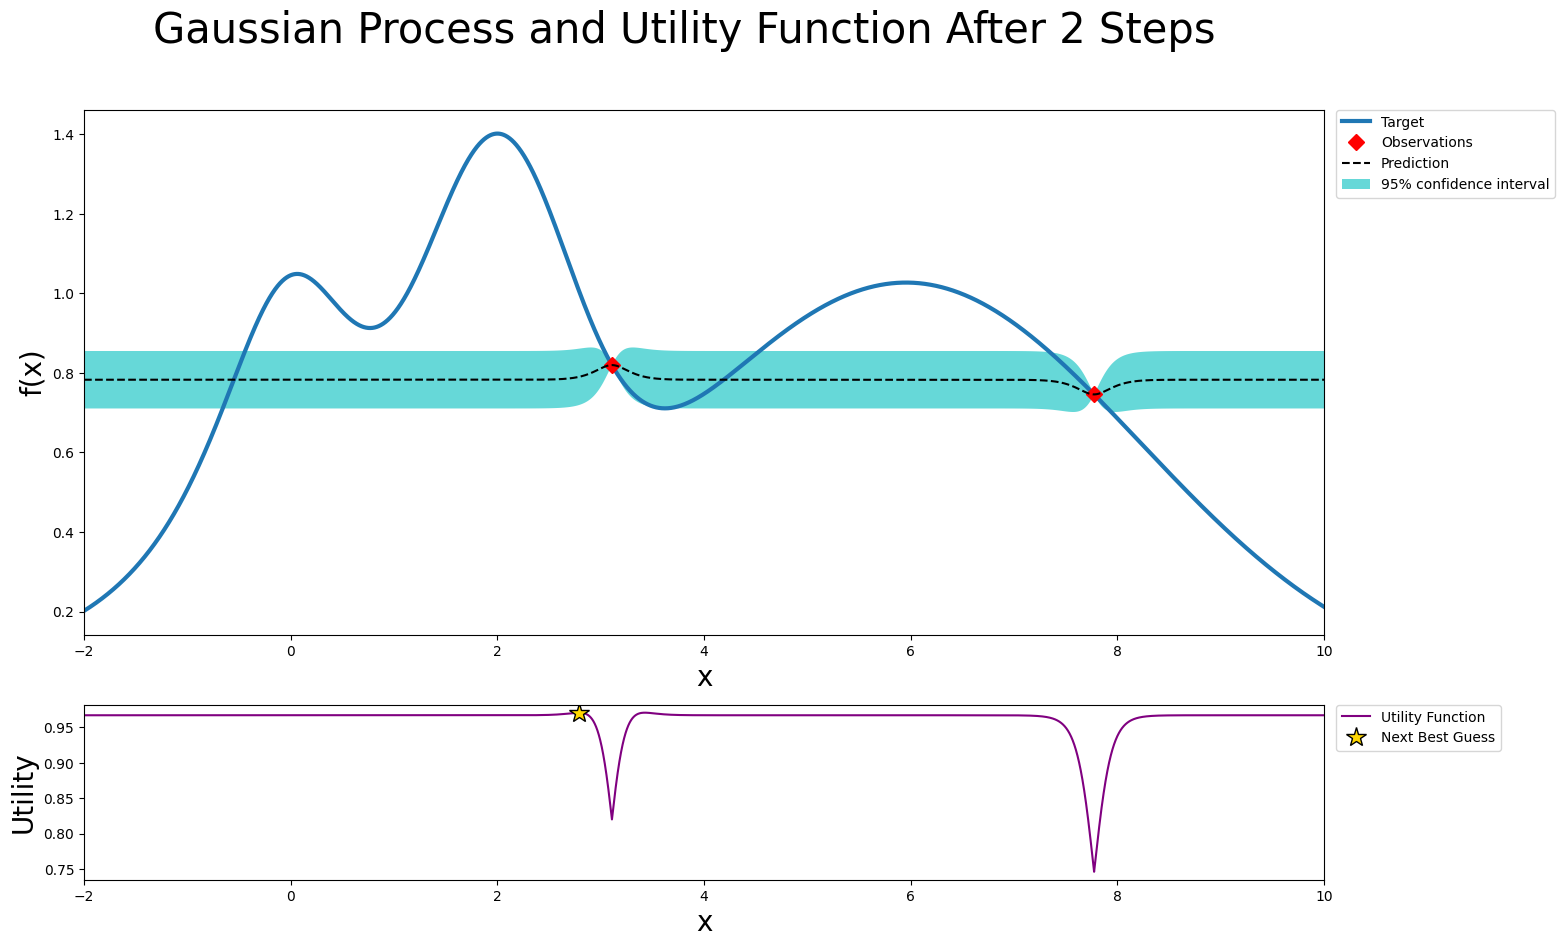

In [ ]:
from bayes_opt import BayesianOptimization
from bayes_opt import acquisition
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

# Define x and y here, before calling plot_gp
x = np.linspace(-2, 10, 10000).reshape(-1, 1)
y = target(x)

plt.plot(x, y);

acquisition_function = acquisition.UpperConfidenceBound(kappa=5.)
optimizer = BayesianOptimization(target, {'x': (-2, 10)}, acquisition_function=acquisition_function, random_state=27)

optimizer.maximize(init_points=2, n_iter=0)

def posterior(optimizer, grid):
    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y): # x and y are passed as arguments now
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontsize=30
    )

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])

    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])

    optimizer.acquisition_function._fit_gp(optimizer._gp, optimizer._space)
    mu, sigma = posterior(optimizer, x)

    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]),
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')

    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})


    utility_function = acquisition.UpperConfidenceBound(kappa=5)
    utility = -1 * utility_function._get_acq(gp=optimizer._gp)(x)
    x = x.flatten()

    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15,
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    #acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})

    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

# Call plot_gp after defining x and y
plot_gp(optimizer, x, y)
plt.savefig('GP and UF after 2 step.png')

|   iter    |  target   |     x     |
-------------------------------------
| 3         | 0.8534    | 4.528     |


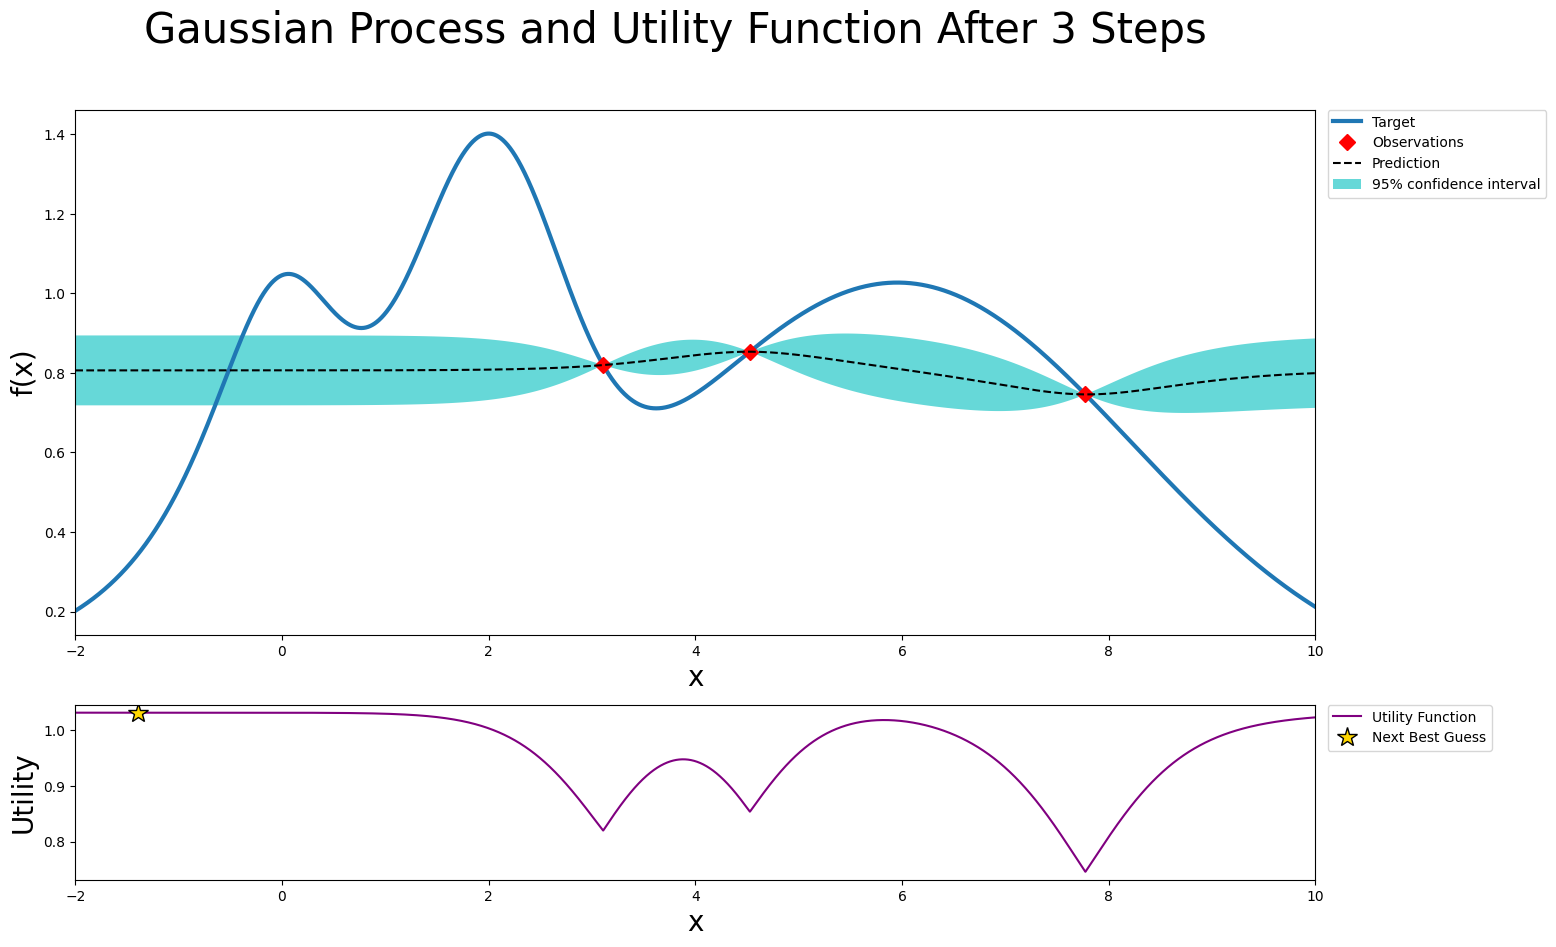

In [ ]:
optimizer.maximize(init_points=0, n_iter=1)
plot_gp(optimizer, x, y)

|   iter    |  target   |     x     |
-------------------------------------
| 4         | 0.3449    | -1.391    |


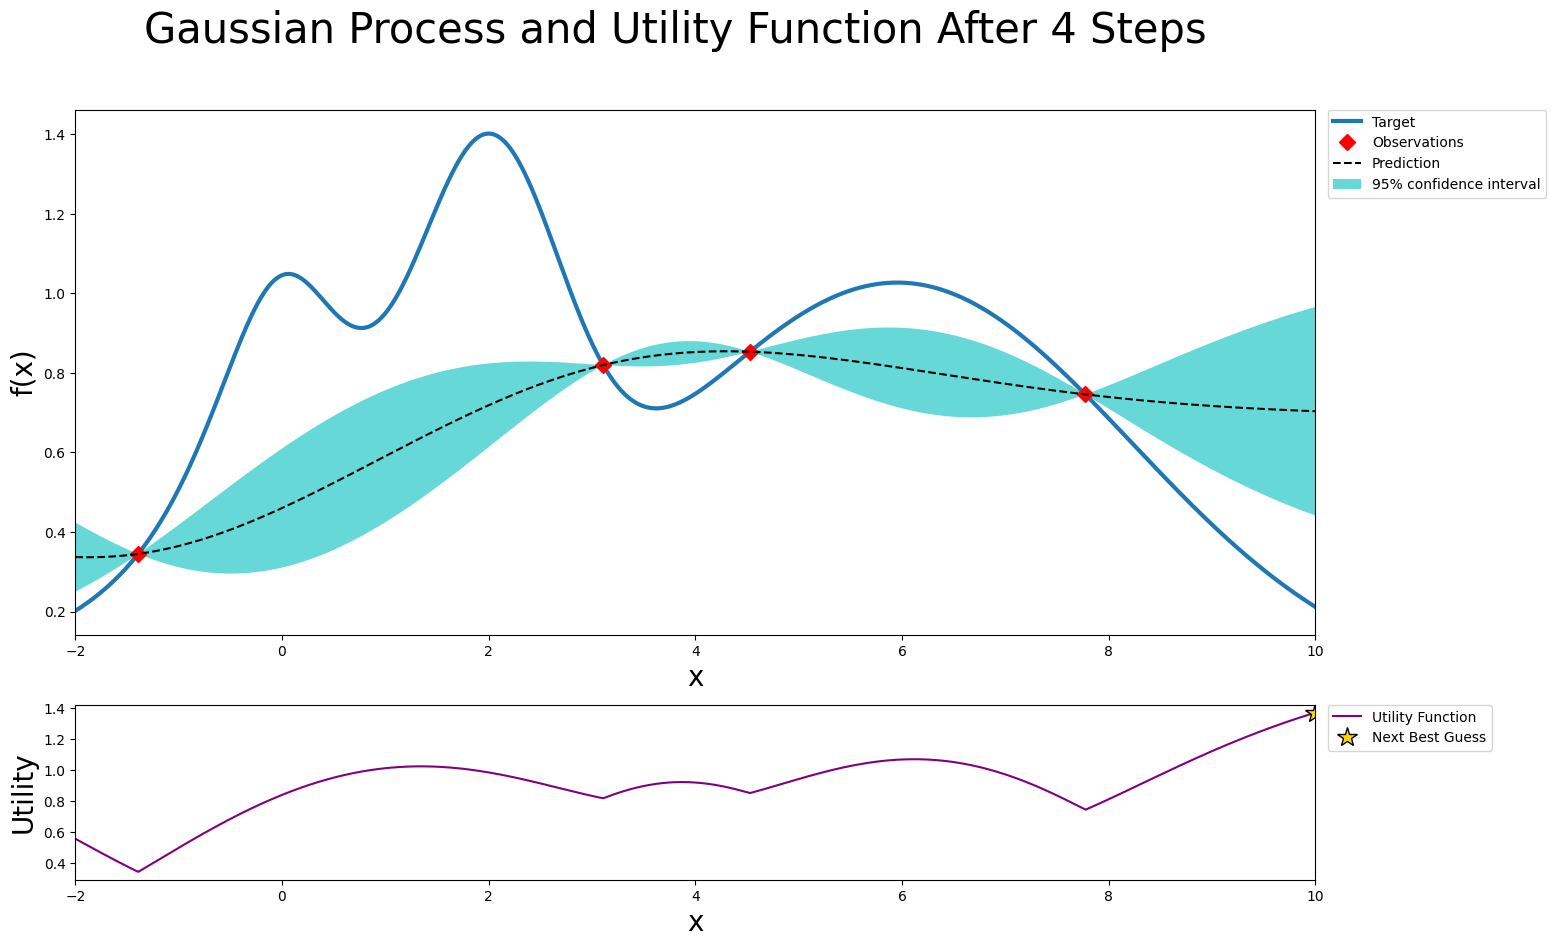

In [ ]:
optimizer.maximize(init_points=0, n_iter=1)
plot_gp(optimizer, x, y)

|   iter    |  target   |     x     |
-------------------------------------
| 5         | 0.2118    | 10.0      |


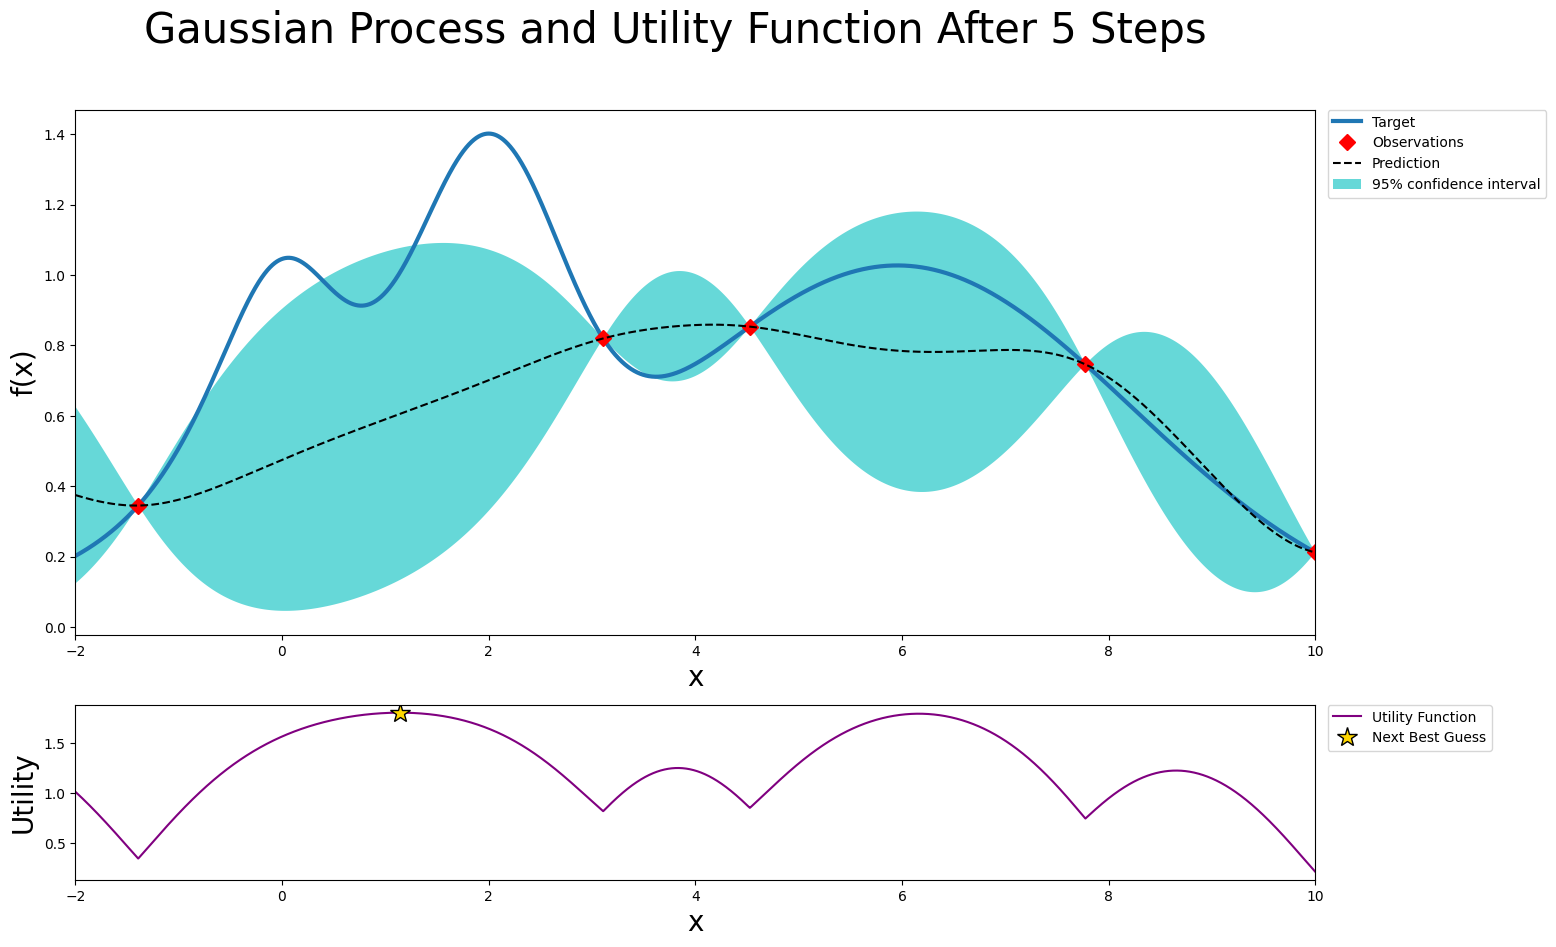

In [ ]:
optimizer.maximize(init_points=0, n_iter=1)
plot_gp(optimizer, x, y)

|   iter    |  target   |     x     |
-------------------------------------
| 6         | 1.007     | 1.141     |
| 7         | 1.025     | 6.113     |
| 8         | 1.043     | 0.1484    |
| 9         | 1.394     | 2.094     |
| 10        | 0.9933    | 5.358     |
| 11        | 1.373     | 2.185     |
| 12        | 0.4779    | 8.767     |
| 13        | 0.9423    | 6.903     |
| 14        | 0.8433    | -0.4597   |
| 15        | 1.338     | 1.722     |


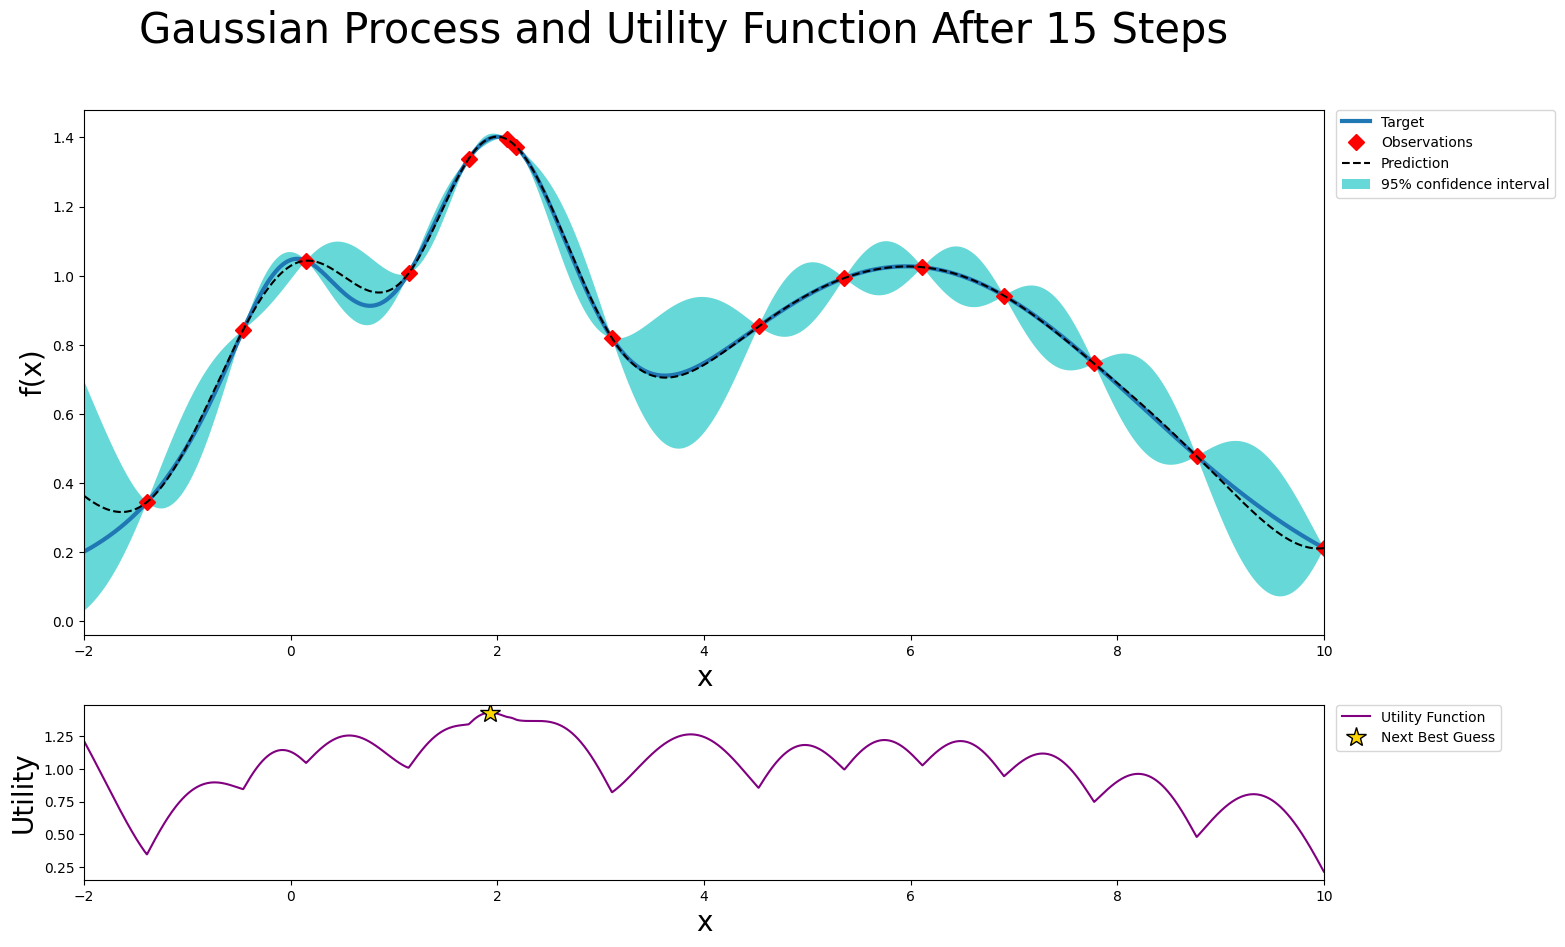

In [ ]:
optimizer.maximize(init_points=0, n_iter=10)
plot_gp(optimizer, x, y)

|   iter    |  target   |     x     |
-------------------------------------
| 16        | 1.398     | 1.93      |
| 17        | 1.402     | 2.002     |
| 18        | 1.402     | 2.003     |
| 19        | 1.402     | 2.0       |
| 20        | 1.402     | 2.003     |
| 21        | 1.402     | 2.002     |
| 22        | 1.402     | 2.002     |
| 23        | 1.402     | 2.001     |
| 24        | 1.402     | 1.996     |
| 25        | 1.402     | 2.013     |


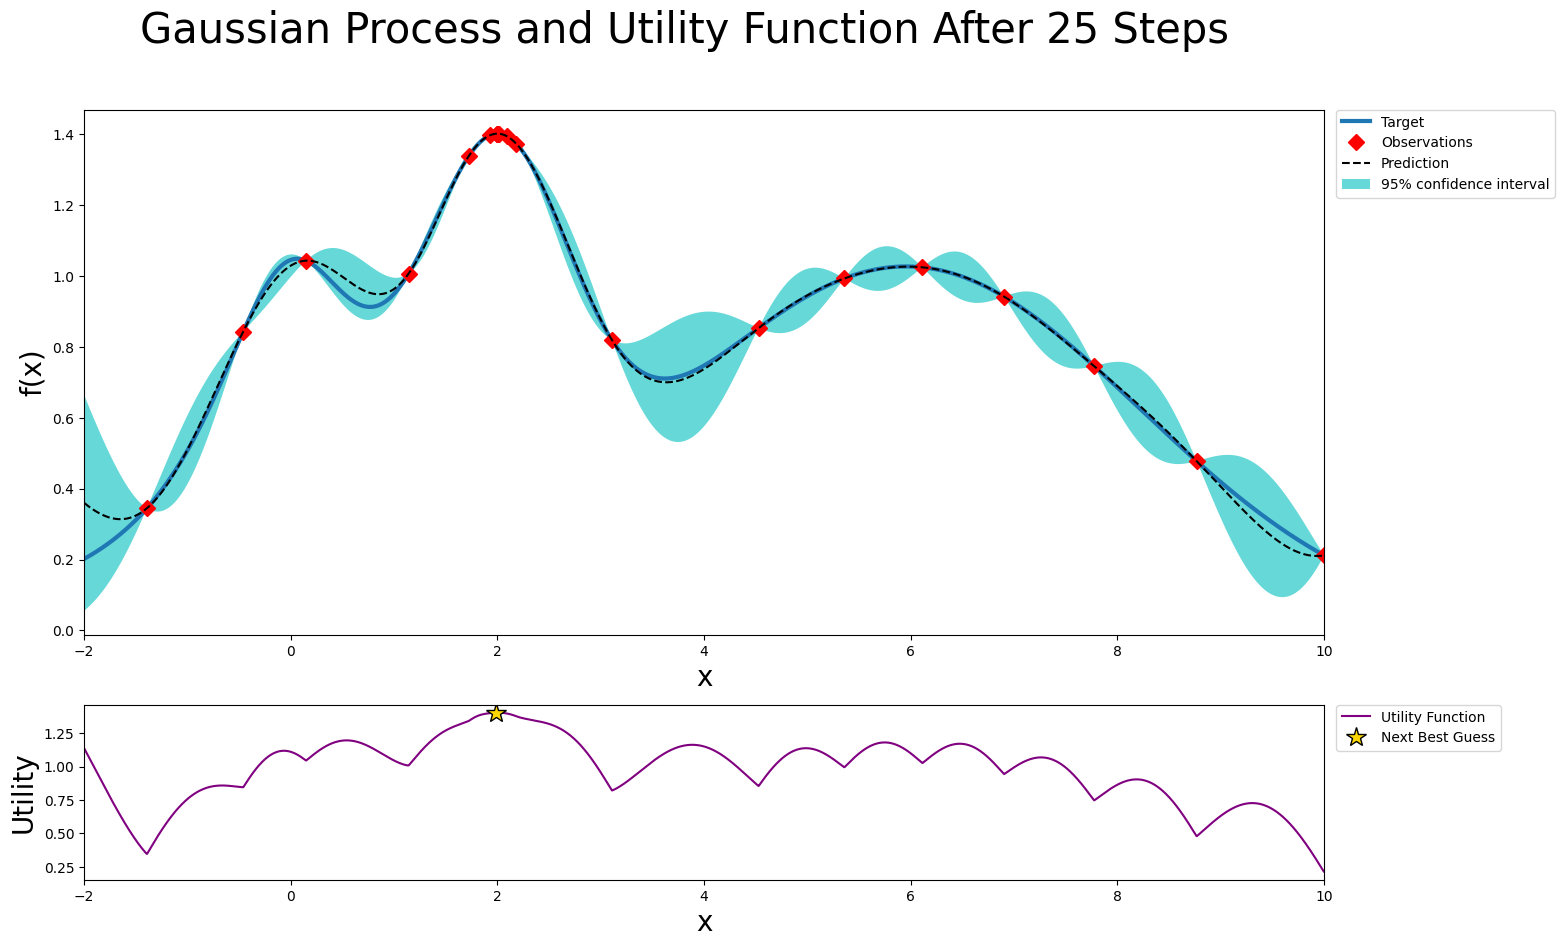

In [ ]:
optimizer.maximize(init_points=0, n_iter=10)
plot_gp(optimizer, x, y)

|   iter    |  target   |     x     |
-------------------------------------
| 26        | 1.402     | 1.992     |
| 27        | 1.402     | 2.01      |
| 28        | 1.402     | 1.993     |
| 29        | 1.402     | 2.012     |
| 30        | 1.402     | 1.992     |
| 31        | 1.402     | 2.011     |
| 32        | 1.402     | 1.992     |
| 33        | 1.402     | 1.992     |
| 34        | 1.402     | 2.011     |
| 35        | 1.402     | 1.993     |


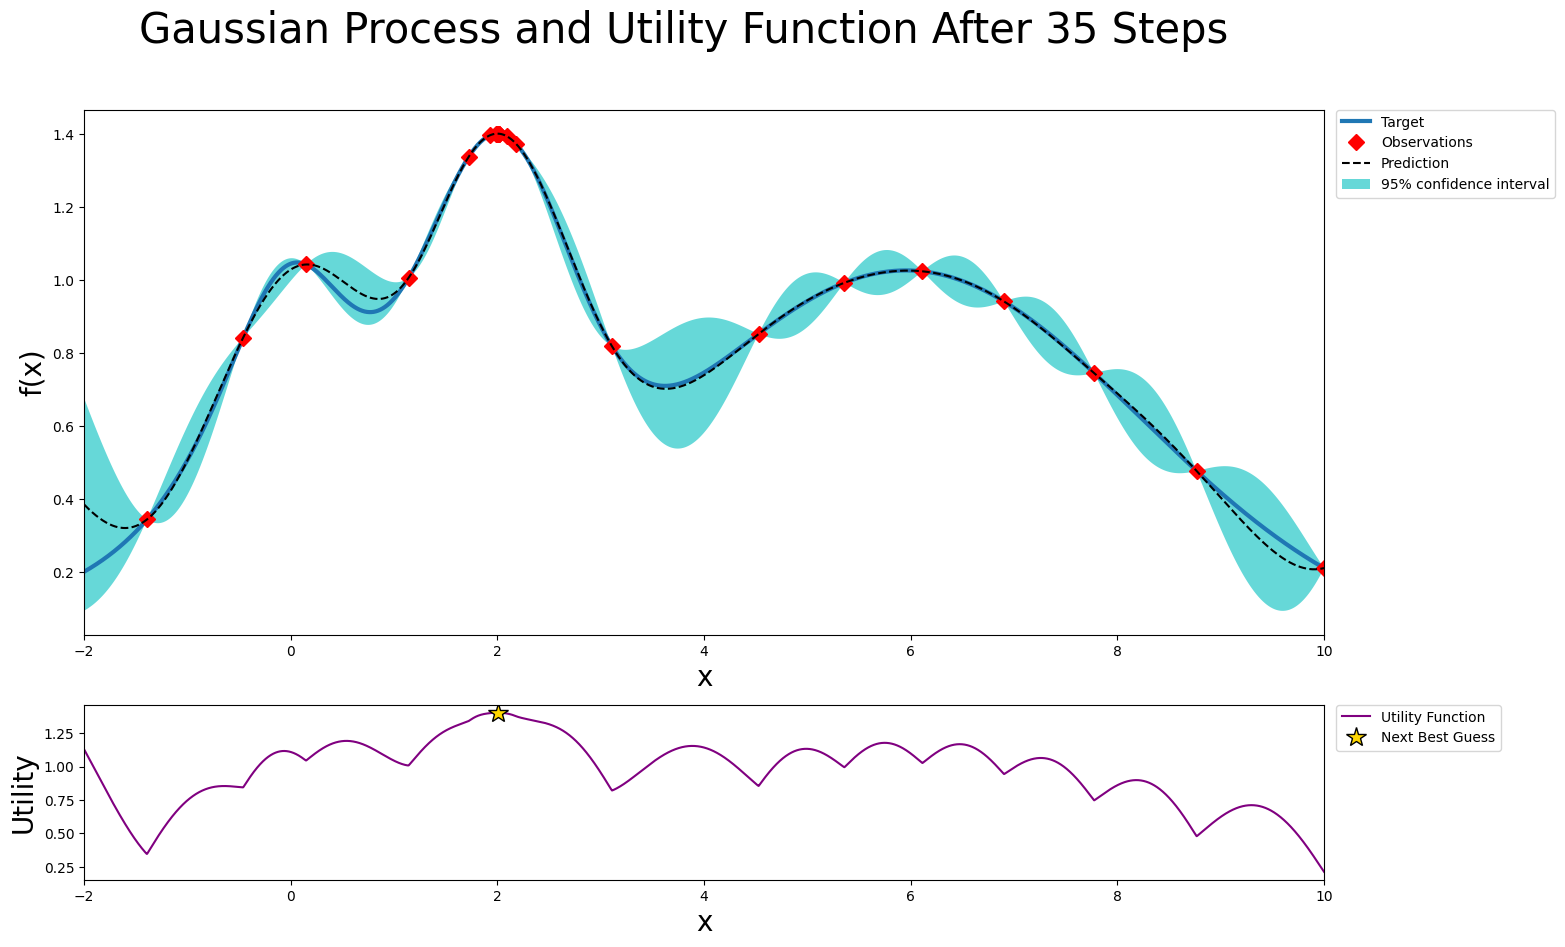

In [ ]:
optimizer.maximize(init_points=0, n_iter=10)
plot_gp(optimizer, x, y)

|   iter    |  target   |     x     |
-------------------------------------
| 36        | 1.402     | 2.011     |
| 37        | 1.402     | 1.994     |
| 38        | 1.402     | 2.01      |
| 39        | 1.402     | 1.994     |
| 40        | 1.402     | 2.009     |
| 41        | 1.402     | 1.993     |
| 42        | 1.402     | 2.01      |
| 43        | 1.402     | 1.993     |
| 44        | 1.402     | 1.993     |
| 45        | 1.402     | 2.01      |


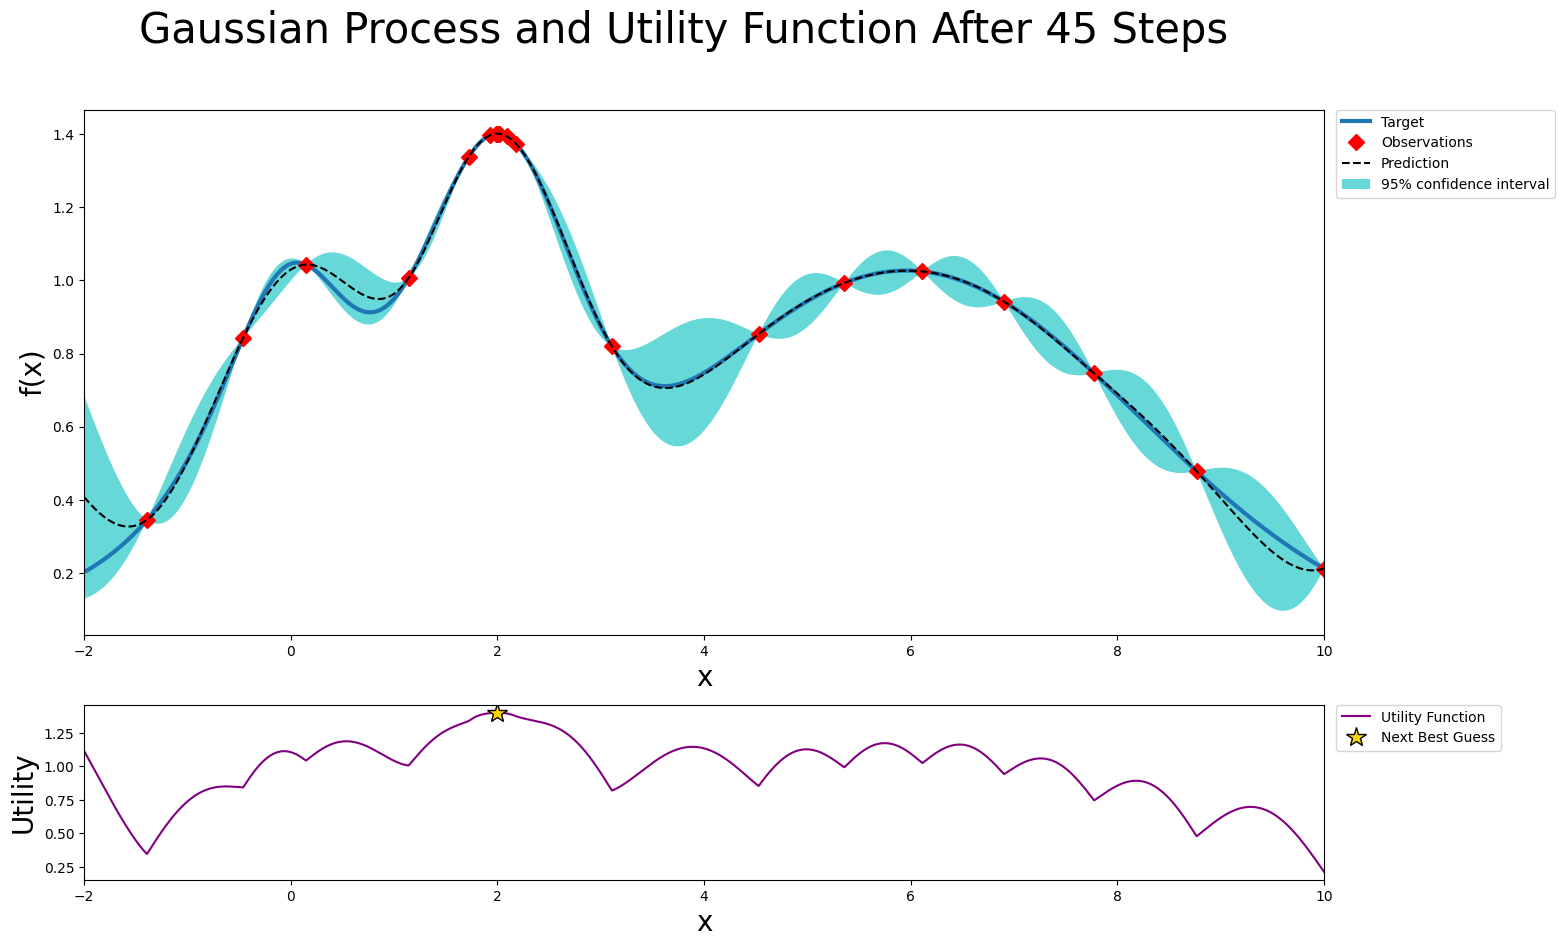

In [ ]:
optimizer.maximize(init_points=0, n_iter=10)
plot_gp(optimizer, x, y)

|   iter    |  target   |     x     |
-------------------------------------
| 3         | 0.8198    | 3.109     |
| 4         | 1.27      | 1.587     |
| 5         | 1.01      | 1.148     |
| 6         | 1.402     | 2.022     |
| 7         | 0.2017    | -2.0      |
| 8         | 0.2119    | 10.0      |
| 9         | 1.017     | 5.634     |
| 10        | 0.8486    | 4.505     |
| 11        | 0.9139    | -0.3479   |
| 12        | 0.9808    | 6.649     |
| 13        | 0.4756    | 8.776     |
| 14        | 1.256     | 2.429     |
| 15        | 1.013     | 0.2958    |
| 16        | 1.388     | 1.876     |
| 17        | 1.389     | 2.122     |
| 18        | 1.402     | 1.98      |
| 19        | 1.402     | 2.003     |
| 20        | 1.402     | 1.999     |
| 21        | 1.402     | 2.012     |
| 22        | 1.402     | 1.988     |
| 23        | 1.402     | 2.012     |
| 24        | 1.402     | 1.989     |
| 25        | 1.402     | 2.011     |
| 26        | 1.402     | 1.991     |
| 27        

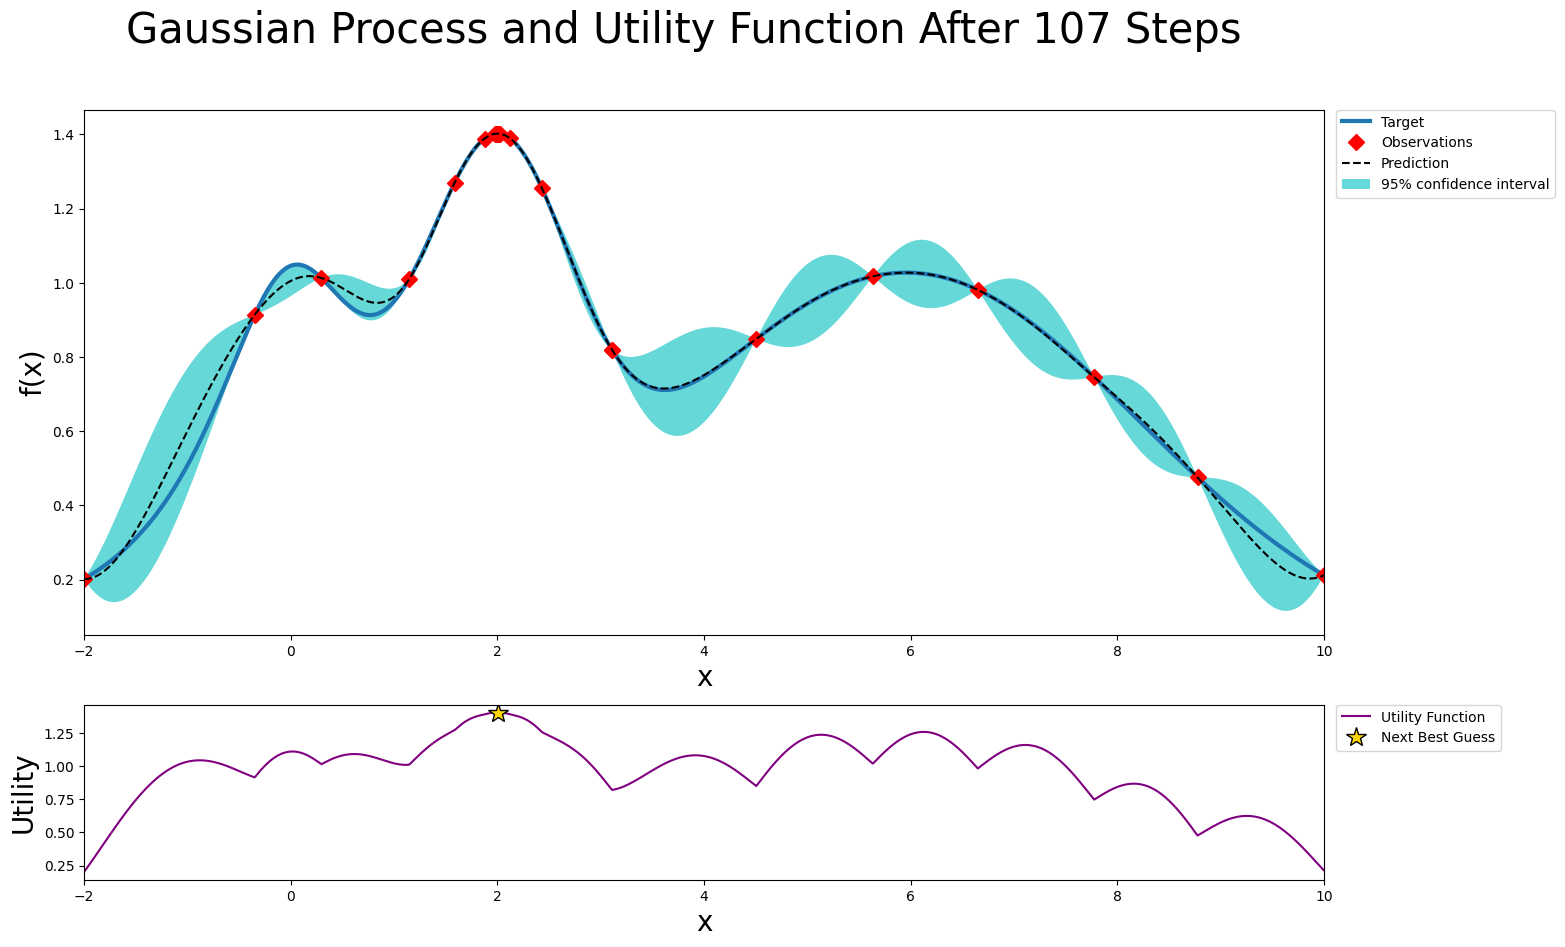

In [ ]:
optimizer.maximize(init_points=0, n_iter=105)
plot_gp(optimizer, x, y)
plt.savefig('GP and UF ffunction after 150 steps.png', dpi=300, bbox_inches='tight')